# Let's compute a daily score of Twitter sentiment analysis

## Import of data and libraries

In [39]:
import sys
import os
import time

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import os
import seaborn as sns 

from datetime import datetime, date

from wordcloud import WordCloud
import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import *
from tqdm import tqdm
#nltk.download('stopwords')

from IPython.display import display, HTML

import yfinance as yf

In [15]:
df = pd.read_csv("/Users/anouaroussalah/Desktop/3A/SM10/Deep Learning/Project/tweets_labelized_2.csv", header=None, names=cols)


/var/folders/v2/_1kj2jc57736h6nlnncs10080000gn/T/ipykernel_27428/1305050679.py:1: DtypeWarning: Columns (1,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/anouaroussalah/Desktop/3A/SM10/Deep Learning/Project/tweets_labelized_2.csv", header=None, names=cols)


In [14]:
cols

['user_name',
 'user_created',
 'user_followers',
 'user_friends',
 'user_favourites',
 'user_verified',
 'date',
 'sentence',
 'predicted label']

In [17]:
df.head(5)

,user_name,user_created,user_followers,user_friends,user_favourites,user_verified,date,sentence,predicted label
0,Iconic Holding,2021-01-05 13:22:24,301.0,1075.0,361.0,False,2021-02-05 10:52:04,2 debunking 9 bitcoin myths by cryptoc...,1.0
1,Iconic Holding,2021-01-05 13:22:24,301.0,1075.0,361.0,False,2021-02-05 10:52:04,weekend read keen to learn about crypto as...,1.0
2,Iconic Holding,2021-01-05 13:22:24,301.0,1075.0,361.0,False,2021-02-05 10:52:06,4 bloomberg lp cryptooutlook 2021 with cr...,1.0
3,Iconic Holding,2021-01-05 13:22:24,301.0,1075.0,361.0,False,2021-02-05 10:52:07,"5 blockchain 50 2021 by , cryptocurren...",1.0
4,Nick Doevendans,2020-06-12 16:50:07,37.0,123.0,410.0,False,2021-02-05 10:52:26,reddcoin rdd to the moon altcoin turnreddcoin...,1.0


In [18]:
len(df)

892058

In [19]:
df = df.drop_duplicates()
len(df)

568925

In [31]:
BTC_df = yf.download('BTC-USD', start="2021-02-05", end="2021-07-25", interval = "1D")
BTC_df.sample(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-01,57714.664062,58448.339844,57052.273438,57828.050781,57828.050781,42836427360
2021-03-22,57517.890625,58471.480469,54288.156250,54529.144531,54529.144531,56521454974
2021-05-10,58250.871094,59519.355469,54071.457031,55859.796875,55859.796875,71776546298
2021-04-23,51739.808594,52120.792969,47714.664062,51093.652344,51093.652344,86668667320
2021-07-24,33593.730469,34490.390625,33424.859375,34292.445312,34292.445312,21664706865
2021-05-29,35684.156250,37234.500000,33693.929688,34616.066406,34616.066406,45231013335
2021-05-03,56620.273438,58973.308594,56590.871094,57200.292969,57200.292969,51713139031
2021-07-15,32827.875000,33159.640625,31175.708984,31780.730469,31780.730469,21300524237
2021-05-06,57441.308594,58363.316406,55382.507812,56396.515625,56396.515625,69523285106


In [32]:
BTC_df["date"] = BTC_df.index
BTC_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 170 entries, 2021-02-05 to 2021-07-24
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Open       170 non-null    float64       
 1   High       170 non-null    float64       
 2   Low        170 non-null    float64       
 3   Close      170 non-null    float64       
 4   Adj Close  170 non-null    float64       
 5   Volume     170 non-null    int64         
 6   date       170 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 10.6 KB


In [99]:
time_grid = pd.DataFrame(BTC_df.index)
time_grid["Date"] = pd.to_datetime(time_grid["Date"]).dt.date
time_grid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    170 non-null    object
dtypes: object(1)
memory usage: 1.5+ KB


In [100]:
time_grid.head(5)

,Date
0,2021-02-05
1,2021-02-06
2,2021-02-07
3,2021-02-08
4,2021-02-09


### Compute log returns 

In [101]:
log_return_open = pd.DataFrame(np.diff(np.log(BTC_df.Open)))
date = pd.DataFrame(list(BTC_df.date)[:-1])

In [102]:
log_return_df = pd.concat([date, log_return_open], axis=1)
log_return_df.columns = ["date", "log_return"]
log_return_df.head(5)

,date,log_return
0,2021-02-05,0.032155
1,2021-02-06,0.028735
2,2021-02-07,-0.009301
3,2021-02-08,0.171999
4,2021-02-09,0.006147


## Compute daily scores

In [63]:
def compute_daily_score(df):
    """
  Compute daily basis with predicted labels
  """
  # Add date column
    df["day_date"] = pd.to_datetime(df.date).dt.date

  # Add score columns
    df["score_positif"] = df["predicted label"].apply(lambda label: 1 if label==2 else 0)
    df["score_neutre"] = df["predicted label"].apply(lambda label: 1 if label==1 else 0)
    df["score_negatif"] = df["predicted label"].apply(lambda label: 1 if label==0 else 0)

  # Weight score with number of followers
    df["weighted_positive_score"] = df.user_followers * df.score_positif
    df["weighted_neutral_score"] = df.user_followers * df.score_neutre
    df["weighted_negative_score"] = df.user_followers * df.score_negatif

  # Aggrgate data on a daily basis
    df_aggregated = df[["day_date", "weighted_positive_score", "weighted_neutral_score", "weighted_negative_score"]].groupby("day_date", as_index=False).sum()

  # Compute total Score
    df_aggregated["total"] = df_aggregated.weighted_positive_score + df_aggregated.weighted_neutral_score + df_aggregated.weighted_negative_score

  # Have percentages for scores 
    df_aggregated.weighted_positive_score = df_aggregated.weighted_positive_score / df_aggregated.total
    df_aggregated.weighted_neutral_score = df_aggregated.weighted_neutral_score / df_aggregated.total
    df_aggregated.weighted_negative_score = df_aggregated.weighted_negative_score / df_aggregated.total

    return df_aggregated

In [75]:
df_score = compute_daily_score(df)

In [76]:
df_score.head(5)

,day_date,weighted_positive_score,weighted_neutral_score,weighted_negative_score,total
0,2021-02-05,0.299347,0.602728,0.097925,7705495.0
1,2021-02-06,0.358841,0.565735,0.075424,16580043.0
2,2021-02-07,0.378946,0.395909,0.225145,12031397.0
3,2021-02-08,0.509324,0.390879,0.099797,48100078.0
4,2021-02-09,0.571424,0.277535,0.151041,31872015.0


In [69]:
len(df_score)

53

In [70]:
df_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   day_date                 53 non-null     object 
 1   weighted_positive_score  53 non-null     float64
 2   weighted_neutral_score   53 non-null     float64
 3   weighted_negative_score  53 non-null     float64
 4   total                    53 non-null     float64
 5   date                     53 non-null     object 
dtypes: float64(4), object(2)
memory usage: 2.6+ KB


There are 120 missing values => too much 

## Fill missing values 

In [95]:
def fill_missing_values(df, time_grid):
    """
    Fill missing values with median values 
    """
    # Join with time grid, to make nan values appear 
    df_merged = pd.merge(time_grid,
                    df_score,
                    how="left",
                    left_on="Date",
                    right_on="day_date")
    
    # Drop date column with nan values, and redundant information
    df_merged.drop(columns="day_date", inplace=True)
    
    # Add a column to spot raws with missing values 
    df_merged["is_missing_value"] = df_merged["total"].isnull().apply(lambda is_na: 1 if is_na else 0)
    
    # Fill missing values with median values
    df_merged = df_merged.fillna(df_merged.median())
    
    return df_merged

In [98]:
df_cleaned = fill_missing_values(df_score, time_grid)
df_cleaned.head(20)

/var/folders/v2/_1kj2jc57736h6nlnncs10080000gn/T/ipykernel_27428/2580586569.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_merged = df_merged.fillna(df_merged.median())


,Date,weighted_positive_score,weighted_neutral_score,weighted_negative_score,total,is_missing_value
0,2021-02-05,0.299347,0.602728,0.097925,7705495.0,0
1,2021-02-06,0.358841,0.565735,0.075424,16580043.0,0
2,2021-02-07,0.378946,0.395909,0.225145,12031397.0,0
3,2021-02-08,0.509324,0.390879,0.099797,48100078.0,0
4,2021-02-09,0.571424,0.277535,0.151041,31872015.0,0
5,2021-02-10,0.538206,0.339476,0.122318,19512280.0,0
6,2021-02-11,0.308056,0.438259,0.225145,20339115.0,1
7,2021-02-12,0.308056,0.438259,0.225145,20339115.0,1
8,2021-02-13,0.242763,0.670931,0.086306,18395935.0,0
9,2021-02-14,0.295322,0.526154,0.178525,15828419.0,0


## Plot daily scores vs daily bitcoin price 

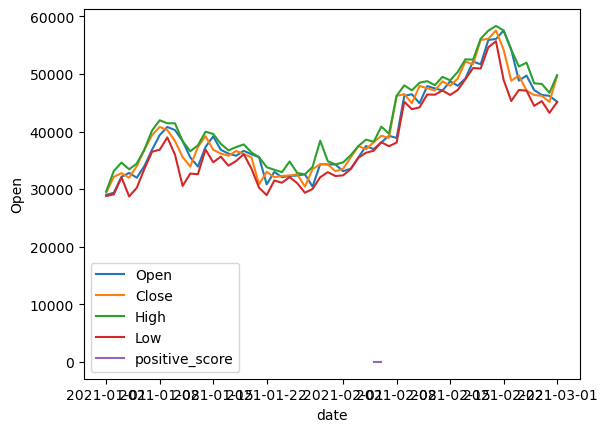

In [35]:
plt.plot(figsize=(20,11))

sns.lineplot(data=BTC_df[BTC_df.date<=datetime(2021,3,1)], x="date", y="Open", label="Open")
sns.lineplot(data=BTC_df[BTC_df.date<=datetime(2021,3,1)], x="date", y="Close", label="Close")
sns.lineplot(data=BTC_df[BTC_df.date<=datetime(2021,3,1)], x="date", y="High", label="High")
sns.lineplot(data=BTC_df[BTC_df.date<=datetime(2021,3,1)], x="date", y="Low", label="Low")
sns.lineplot(data=df_test, x='date', y="weighted_positive_score", label="positive_score" )
plt.legend()
plt.show()


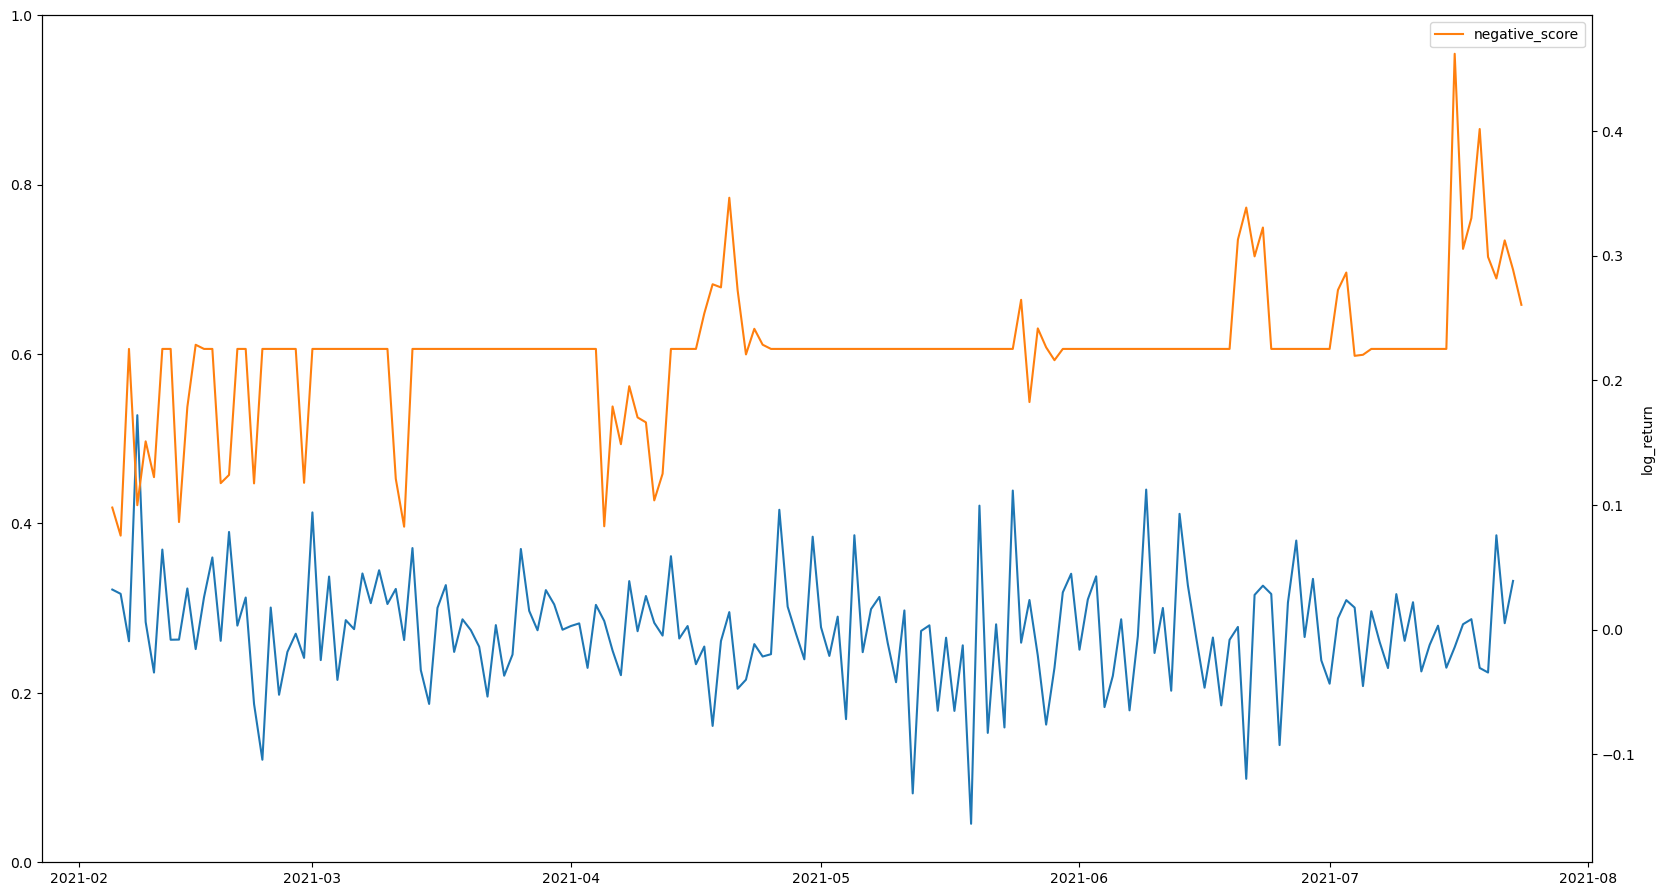

In [105]:
plt.figure(figsize=(20,11))

ax2 = plt.twinx()
#sns.lineplot(data=BTC_df, x="date", y="Open", label="Open")
#sns.lineplot(data=BTC_df, x="date", y="Close", label="Close")
#sns.lineplot(data=BTC_df, x="date", y="High", label="High")
#sns.lineplot(data=BTC_df, x="date", y="Low", label="Low")
sns.lineplot(data=log_return_df, x='date', y="log_return")
#sns.lineplot(data=df_test, x='date', y="weighted_positive_score", label="positive_score" , ax=ax2)
sns.lineplot(data=df_cleaned, x='Date', y="weighted_negative_score", label="negative_score" , ax=ax2)
#sns.lineplot(data=df_test, x='date', y="weighted_neutral_score", label="neutral_score" , ax=ax2)
plt.legend()
plt.show()
